In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

In [2]:
# loading data after merging all last 12 months of ride data (jul 2023 to jun 2024)
df = pd.read_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\2022-2024\combined.parquet')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14541519 entries, 0 to 14541518
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 1.4+ GB


In [38]:
#stations dataframe
df2 = pd.read_csv(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\2022-2024\Divvy_Bicycle_Stations_20240814.csv')

In [40]:
df2.head()

,ID,Station Name,Short Name,Total Docks,Docks in Service,Status,Latitude,Longitude,Location
0,a3ad5c90-a135-11e9-9cda-0a87ae2ba916,Dorchester Ave & 49th St,KA1503000069,15,15,In Service,41.805772,-87.592464,POINT (-87.592464 41.805772)
1,1571105068000485406,Narragansett & Irving Park,NaN,9,9,In Service,41.952614,-87.785383,POINT (-87.7853829 41.952614)
2,a3b2af02-a135-11e9-9cda-0a87ae2ba916,MLK Jr Dr & 83rd St,586,11,11,In Service,41.743116,-87.614800,POINT (-87.6148 41.743116)
3,1594046405283107528,California & 16th St,NaN,9,9,In Service,41.859228,-87.695562,POINT (-87.695562 41.859228)
4,a3b13836-a135-11e9-9cda-0a87ae2ba916,Kenton Ave & Madison St,537,11,11,In Service,41.880708,-87.741018,POINT (-87.741018 41.880708)


# A - Data cleaning:

## Setting requirement

1. [x] Adding calcualted columns: ride distance, time start, time end, ride length, week day, month, time
2. [x] Clean outliers data: check start date - end date logic 
3. [x] Convert start and end stations to neighourhoods
4. [x] Mapping neighborhood to stations data frame

### Adding calculated columns

In [3]:
# adding distance column using math library

import math

def haversine(row):
    start_lat, start_lgn = row['start_lat'], row['start_lng']
    end_lat, end_lng = row['end_lat'], row['end_lng']    

    # Convert latitude and longitude from degrees to radians
    start_lat = math.radians(start_lat)
    start_lgn = math.radians(start_lgn)
    end_lat = math.radians(end_lat)
    end_lng = math.radians(end_lng)

    # Differences between the two points
    dlat = start_lat - end_lat
    dlon = start_lgn - end_lng

    # Haversine formula
    a = math.sin(dlat / 2) ** 2 + math.cos(start_lat) * math.cos(end_lat) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of the Earth in kilometers. Use 3956 for miles
    R = 6371.0

    # Distance in kilometers
    distance = R * c

    return distance

In [4]:
# adding distance column to dataframe

df['distance_km'] = df.apply(haversine, axis =1)

In [9]:
df.sample(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance_km
5623426,93DC6278E3FDAC9C,classic_bike,2024-06-05 07:02:05.538,2024-06-05 07:19:10.321,Ashland Ave & Augusta Blvd,13248,McClurg Ct & Erie St,KA1503000041,41.899643,-87.667700,41.894503,-87.617854,member,4.165028
3504822,10F57BCAB5721C06,classic_bike,2024-02-07 15:17:12,2024-02-07 15:27:56,Canal St & Taylor St,15550,Sangamon St & Washington Blvd,13409,41.870257,-87.639474,41.883165,-87.651100,member,1.728185
2799938,AC8F6E6A7AC5D920,classic_bike,2023-11-19 14:51:42,2023-11-19 15:26:37,Shore Dr & 55th St,TA1308000009,Woodlawn Ave & 75th St,569,41.795212,-87.580715,41.759160,-87.595751,member,4.198219
2109565,BC5CA4D65F1B36EA,classic_bike,2023-09-24 13:05:30,2023-09-24 13:24:52,Millennium Park,13008,Streeter Dr & Grand Ave,13022,41.881032,-87.624084,41.892278,-87.612043,casual,1.599195
981368,4A4B07AA6767B32B,electric_bike,2023-08-04 23:21:12,2023-08-04 23:26:32,Clark St & Elm St,TA1307000039,Larrabee St & Oak St,KA1504000116,41.902856,-87.631673,41.900219,-87.642985,casual,0.981079
288332,663368195D9B8777,classic_bike,2023-07-29 15:32:45,2023-07-29 15:42:43,Southport Ave & Irving Park Rd,TA1309000043,Greenview Ave & Diversey Pkwy,13294,41.954177,-87.664358,41.932590,-87.665936,member,2.403953
2330800,5EC18E44E474D02E,classic_bike,2023-10-16 05:12:04,2023-10-16 13:20:54,Broadway & Belmont Ave,13277,Broadway & Belmont Ave,13277,41.940106,-87.645451,41.940106,-87.645451,member,0.000000
5472663,7B87D6FD014817D2,electric_bike,2024-06-04 18:45:20.857,2024-06-04 18:56:13.959,DuSable Lake Shore Dr & Belmont Ave,TA1309000049,None,None,41.940746,-87.639076,41.930000,-87.640000,casual,1.197366
856569,CC909EA1DD86685C,classic_bike,2023-08-02 17:57:00,2023-08-02 18:09:13,Ashland Ave & Grand Ave,13434,LaSalle St & Illinois St,13430,41.891072,-87.666611,41.890762,-87.631697,member,2.890227
3355724,7A2131571844C007,classic_bike,2024-01-31 20:00:13,2024-01-31 20:13:07,Central Park Ave & Bloomingdale Ave,18017,Humboldt Blvd & Armitage Ave,15651,41.914166,-87.716755,41.917513,-87.701809,member,1.291482


In [5]:
# convert started_at and ended_at to date time
df['started_at'] = pd.to_datetime(df['started_at'],format='mixed')
df['ended_at'] = pd.to_datetime(df['ended_at'], format='mixed')

In [6]:
# adding ride length:
df['ride_length'] = df['ended_at'] - df['started_at']

In [7]:
#sample data of ride_length

df['ride_length'].sample(10)

1458732    0 days 00:04:20
5938942    0 days 00:03:14
2584323    0 days 00:00:47
12196370   0 days 00:11:28
6528967    0 days 00:08:45
10680774   0 days 00:07:40
10897834   0 days 01:27:06
9854276    0 days 00:11:05
9890773    0 days 00:08:37
338960     0 days 00:04:21
Name: ride_length, dtype: timedelta64[ns]

In [8]:
# convert ride length to minutes
df['ride_length_minutes'] = round(df['ride_length'].dt.total_seconds()/60,2)

In [9]:
df['distance_km'] = round(df['distance_km'],2)

In [10]:
# adding month column
df['month'] = df['started_at'].dt.month

In [11]:
df['year'] = df['started_at'].dt.year

In [12]:
# adding time column for the start of the ride
df['time'] = df['started_at'].dt.strftime('%H:%M')

In [13]:
df['time_hr'] = df['started_at'].dt.strftime('%H')

In [14]:
# adding day of week when the ride occured
df['day_of_week'] = df['started_at'].dt.day_name()

In [15]:
df.sample(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance_km,ride_length,ride_length_minutes,month,time,date_diff
2600807,06702E36B2498B40,classic_bike,2023-10-23 09:21:20.000,2023-10-23 09:24:46.000,Blackstone Ave & 59th St,22004,University Ave & 59th St,22003,41.787877,-87.590461,41.787878,-87.598906,member,0.70,0 days 00:03:26,3.43,10,09:21,0
833617,C822079643FFB414,electric_bike,2023-08-16 18:01:05.000,2023-08-16 18:05:17.000,Clybourn Ave & Division St,TA1307000115,Wells St & Institute Pl,22001,41.904597,-87.640582,41.897380,-87.634420,casual,0.95,0 days 00:04:12,4.20,8,18:01,0
5456090,4BF42BF48FEB6A2E,electric_bike,2024-06-08 14:57:21.114,2024-06-08 15:14:15.302,None,None,None,None,41.980000,-87.650000,41.980000,-87.680000,member,2.48,0 days 00:16:54.188000,16.90,6,14:57,0
158137,975042D92E26FC4B,electric_bike,2023-07-27 18:35:47.000,2023-07-27 18:39:27.000,Morgan St & 18th St,13163,Clinton St & 18th St,TA1307000044,41.858045,-87.651030,41.857950,-87.640826,casual,0.85,0 days 00:03:40,3.67,7,18:35,0
3788142,B2F7CAD175B27ABF,classic_bike,2024-03-02 14:28:03.000,2024-03-02 15:03:45.000,Clark St & Elm St,TA1307000039,DuSable Lake Shore Dr & Monroe St,13300,41.902973,-87.631280,41.880958,-87.616743,casual,2.73,0 days 00:35:42,35.70,3,14:28,0
75069,B63A1455EE5DF5E1,classic_bike,2023-07-08 17:13:54.000,2023-07-08 17:18:09.000,Clark St & Drummond Pl,TA1307000142,Halsted St & Wrightwood Ave,TA1309000061,41.931248,-87.644336,41.929143,-87.649077,member,0.46,0 days 00:04:15,4.25,7,17:13,0
2448754,CA65DE005C2747E9,classic_bike,2023-10-03 08:22:40.000,2023-10-03 08:38:24.000,Halsted St & Fulton St,23003,Sedgwick St & Webster Ave,13191,41.886871,-87.648089,41.922167,-87.638888,casual,4.00,0 days 00:15:44,15.73,10,08:22,0
252778,E0341EB9131C7C56,classic_bike,2023-07-14 11:10:45.000,2023-07-14 11:23:13.000,Lincoln Ave & Belle Plaine Ave,TA1309000026,Damen Ave & Clybourn Ave,13271,41.956004,-87.680161,41.931931,-87.677856,member,2.68,0 days 00:12:28,12.47,7,11:10,0
3467037,42BF50DC83C93FEF,classic_bike,2024-01-25 14:40:03.000,2024-01-25 15:06:37.000,Clark St & Lake St,KA1503000012,Conservatory Dr & Lake St,518,41.886021,-87.630876,41.885502,-87.716866,casual,7.12,0 days 00:26:34,26.57,1,14:40,0
3192857,337634ED7E324EF9,classic_bike,2023-12-25 10:54:27.000,2023-12-25 11:04:02.000,Clark St & Drummond Pl,TA1307000142,Southport Ave & Wrightwood Ave,TA1307000113,41.931248,-87.644336,41.928773,-87.663913,member,1.64,0 days 00:09:35,9.58,12,10:54,0


### Clean outliers

In [15]:
df['date_diff'] = df['ride_length'].dt.days

In [16]:
row_to_drop = df[df['date_diff'] < 0].index

In [17]:
df = df.drop(row_to_drop, axis = 0)

In [18]:
# drop date_diff
df = df.drop('date_diff', axis=1)

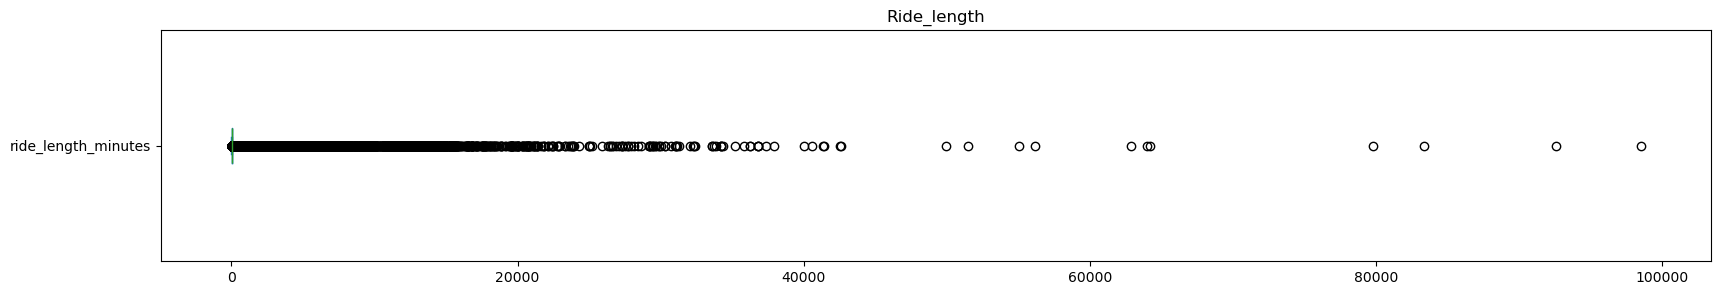

The upper limit for price is 35.894999999999996
The lower limit for price is -12.544999999999998
There are 1079503 rows have price higher than upper limit accounting for 7.42% of total


In [19]:
# clean out trips that has outliers length

fig, ax = plt.subplots(figsize=(20,3))
df['ride_length_minutes'].plot(kind = 'box', vert = False)
ax.set_title('Ride_length')
plt.show()

# identify the outliers with 1.5*IQR rules - price column:
length_Q1 = df['ride_length_minutes'].quantile(0.25)
length_Q3 = df['ride_length_minutes'].quantile(0.75)
length_IQR = length_Q3 - length_Q1
length_upper_bound = length_Q3 + 1.5*length_IQR
length_lower_bound = length_Q1 - 1.5*length_IQR
upper_num = len(df[df['ride_length_minutes'] > length_upper_bound])

print(f'The upper limit for price is {length_upper_bound}')
print(f'The lower limit for price is {length_lower_bound}')
print(f'There are {upper_num} rows have price higher than upper limit accounting for {round(upper_num*100/len(df),2)}% of total')

In [20]:
# drop outliers trip length
df = df.drop(df[df['ride_length_minutes']> length_upper_bound].index, axis = 0)

### Adding neighborhoods area: 
For the ease of visualization about the utilization of bikes in specific neighborhoods, I made use of the geojson file of Chicago and map out the specific neighborhoods to start and end location.

In [21]:
import geopandas as gpd
from shapely.geometry import Point

In [22]:
# loading the neighbourhoods map
neighborhoods = gpd.read_file(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\Data analytics\chicago.geojson')

c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [23]:
geometry = [Point(xy) for xy in zip(df.start_lng, df.start_lat)]

In [24]:
# Convert DataFrame to GeoDataFrame
df = gpd.GeoDataFrame(df, geometry=geometry)

In [25]:
# Set the same coordinate reference system (CRS) for both GeoDataFrames
df.crs = neighborhoods.crs

In [26]:
# Perform spatial join to assign neighborhood names to each bike station
df = gpd.sjoin(df, neighborhoods, how='left', op='within')

c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [27]:
column_to_drop2 = ['geometry','index_right','cartodb_id','created_at','updated_at']

In [28]:
df = df.drop(column_to_drop2, axis = 1)

In [29]:
df.rename(columns = {'name' : 'start_neighborhood'}, inplace = True)

In [30]:
# repeat the same routine for end neigbourhood:
geometry2 = [Point(xy) for xy in zip(df.end_lng, df.end_lat)]
df = gpd.GeoDataFrame(df, geometry=geometry2)

In [31]:
df.crs = neighborhoods.crs
df = gpd.sjoin(df, neighborhoods, how='left', op='within')


c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [32]:
df = df.drop(column_to_drop2, axis = 1)
df.rename(columns = {'name' : 'end_neighborhood'}, inplace = True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14540968 entries, 0 to 14541518
Data columns (total 23 columns):
 #   Column               Dtype          
---  ------               -----          
 0   ride_id              object         
 1   rideable_type        object         
 2   started_at           datetime64[ns] 
 3   ended_at             datetime64[ns] 
 4   start_station_name   object         
 5   start_station_id     object         
 6   end_station_name     object         
 7   end_station_id       object         
 8   start_lat            float64        
 9   start_lng            float64        
 10  end_lat              float64        
 11  end_lng              float64        
 12  member_casual        object         
 13  distance_km          float64        
 14  ride_length          timedelta64[ns]
 15  ride_length_minutes  float64        
 16  month                int32          
 17  year                 int32          
 18  time                 object         
 19  tim

### Mapping neighborhood to stations data frame

In [42]:
geometry3 = df2['Location']
df2 = gpd.GeoDataFrame(df2, geometry=geometry3)

df2.crs = neighborhoods.crs

df2 = gpd.sjoin(df2, neighborhoods, how='left', op='within')

c:\Users\tamla_f1yewqh\anaconda3\envs\divvy\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [44]:
df2 = df2.drop(column_to_drop2,axis =1)
df2.rename(columns={'name':'station_neighborhood'}, inplace= True)

# B - Data exploratory analysis
What is the landscape look like over the last 12 months


## 1. Bike ride characteristics:
- [ ] What is the seasonality characteristics of bike sharing? Identify the peak months, peak hours of ride
- [ ] What are the most popular routes of ride?

In [27]:
df_ltm = df[(df['started_at'] <= '2024-07-31') & (df['started_at'] >= '2023-08-01')]

In [28]:
len(df_ltm)

5687897

In [29]:
# monthly ride number
ride_by_month = df_ltm.groupby('month').count()['ride_id'].reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ride_by_month['month'] = month_order
ride_by_month.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

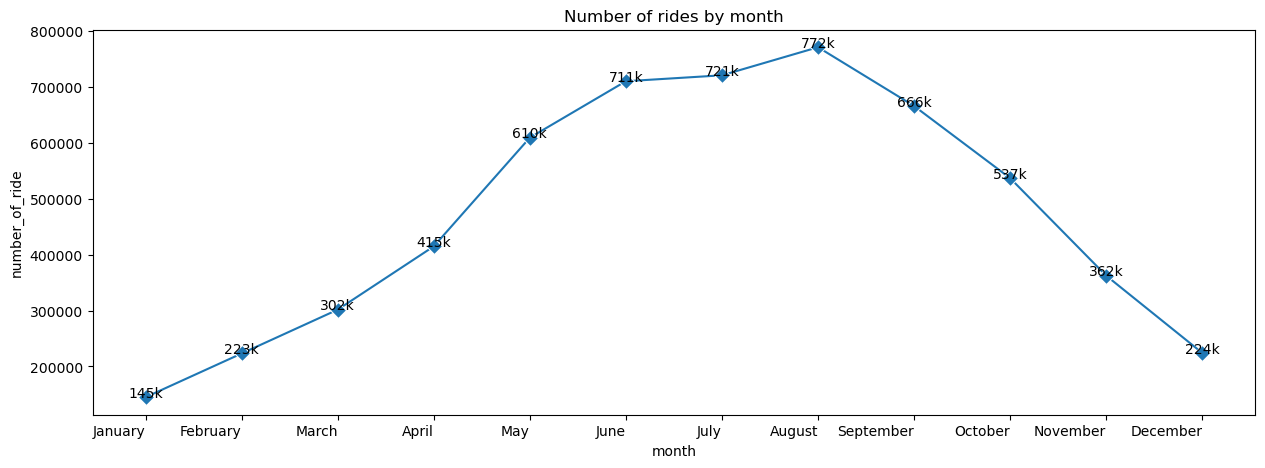

In [30]:
# plotting chart
fig, ax = plt.subplots(figsize=(15,5))

sns.lineplot(data = ride_by_month,x='month', y ='number_of_ride', marker = "D", markersize = 8)
plt.xticks(rotation=0, ha='right', fontsize=10)
for x, y in zip(ride_by_month['month'], ride_by_month['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', size = 10)
plt.title('Number of rides by month')
plt.show()


In [31]:
# ride by hours
ride_by_hr = df_ltm.groupby('time_hr').count()['ride_id'].reset_index()
ride_by_hr.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

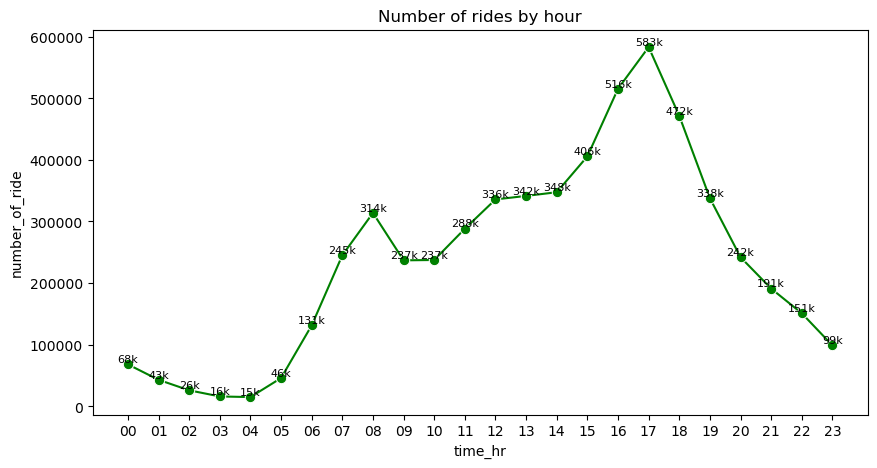

In [32]:
# plotting ride by hour
fig, ax = plt.subplots(figsize = (10,5))

sns.lineplot(data = ride_by_hr,x='time_hr', y ='number_of_ride', marker = ".", markersize = 15, color = 'green')
plt.xticks(rotation=0, ha='center', fontsize=10)
for x, y in zip(ride_by_hr['time_hr'], ride_by_hr['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', va = 'bottom', size = 8)
plt.title('Number of rides by hour')
plt.show()


In [33]:
# ride by weekday
ride_by_week = df_ltm.groupby('day_of_week').count()['ride_id'].reset_index()
day_order = ['Monday','Tuesday', 'Wednesday','Thursday','Friday', 'Saturday','Sunday']
ride_by_week['day_of_week'] = pd.Categorical(ride_by_week['day_of_week'], categories=day_order, ordered= True)
ride_by_week.rename(columns={'ride_id':'number_of_ride'}, inplace=True)
ride_by_week = ride_by_week.sort_values(by='day_of_week')

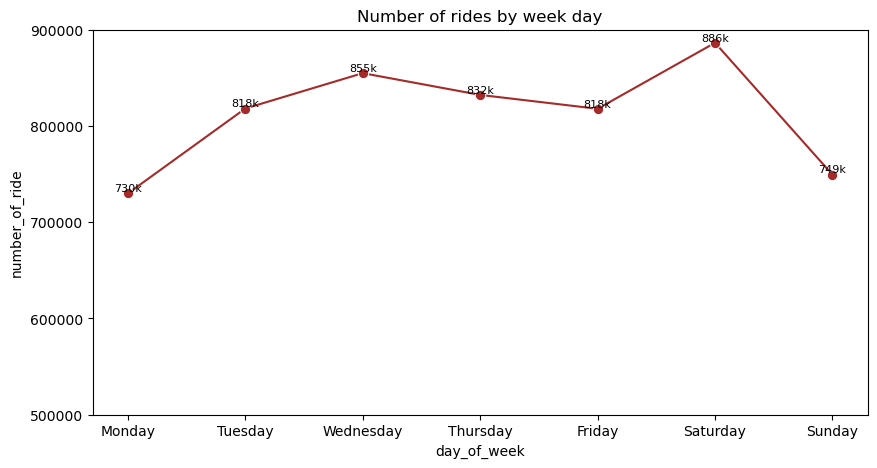

In [34]:
# plotting chart
fig, ax = plt.subplots(figsize = (10,5))

sns.lineplot(data = ride_by_week,x='day_of_week', y ='number_of_ride', marker = ".", markersize = 15, color = 'brown')
plt.xticks(rotation=0, ha='center', fontsize=10)
for x, y in zip(ride_by_week['day_of_week'], ride_by_week['number_of_ride']):
    plt.text(x=x,y=y,s=f'{y/1000:.0f}k', ha ='center', va = 'bottom', size = 8)
plt.yticks(range(500000, 1000000, 100000))
plt.title('Number of rides by week day')
plt.show()

The peak season is from June to August.
The peak hours are from 7am-8:30am and 4pm-6pm, which may match with the going-to-work and off-work hours.
The usage spread quite equally among week days and peaked during Saturday

In [35]:
df_ltm['route'] = df_ltm['start_station_id'] + '-' + df_ltm['end_station_id']

C:\Users\tamla_f1yewqh\AppData\Local\Temp\ipykernel_34324\1443810033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ltm['route'] = df_ltm['start_station_id'] + '-' + df_ltm['end_station_id']


In [39]:
df_ltm.sample(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,distance_km,ride_length,ride_length_minutes,month,time,time_hr,day_of_week,year,route
14223965,BF1D2979EFDBF84A,classic_bike,2024-07-02 18:14:49.390,2024-07-02 18:29:01.260,Racine Ave & 15th St,13304,Wentworth Ave & Cermak Rd*,chargingstx07,41.861267,-87.656625,...,casual,2.24,0 days 00:14:11.870000,14.20,7,18:14,18,Tuesday,2024,13304-chargingstx07
10895439,5001AD0B890060EB,classic_bike,2023-11-12 08:45:08.000,2023-11-12 09:01:18.000,Washtenaw Ave & Lawrence Ave,KA1504000080,Damen Ave & Foster Ave,KA1504000149,41.968987,-87.696027,...,casual,1.56,0 days 00:16:10,16.17,11,08:45,08,Sunday,2023,KA1504000080-KA1504000149
13694256,604E3404C11B61C8,electric_bike,2024-06-27 21:26:20.335,2024-06-27 21:32:47.546,None,None,McClurg Ct & Ohio St,TA1306000029,41.890000,-87.630000,...,member,1.09,0 days 00:06:27.211000,6.45,6,21:26,21,Thursday,2024,NaN
12347737,482812F1588B824D,electric_bike,2024-04-14 17:24:08.000,2024-04-14 17:24:51.000,None,None,None,None,41.950000,-87.660000,...,member,0.00,0 days 00:00:43,0.72,4,17:24,17,Sunday,2024,NaN
13760785,5A63800F4268FE7E,electric_bike,2024-06-02 14:34:53.481,2024-06-02 14:50:50.782,None,None,None,None,41.960000,-87.660000,...,member,1.39,0 days 00:15:57.301000,15.96,6,14:34,14,Sunday,2024,NaN
9840288,926219479DE2F597,classic_bike,2023-09-06 22:00:10.000,2023-09-06 22:07:29.000,Morgan St & Polk St,TA1307000130,Racine Ave & Congress Pkwy,TA1306000025,41.871737,-87.651030,...,member,0.59,0 days 00:07:19,7.32,9,22:00,22,Wednesday,2023,TA1307000130-TA1306000025
13192136,F100D39E2CDC8ED5,classic_bike,2024-06-03 17:43:31.705,2024-06-03 17:51:26.499,Damen Ave & Pierce Ave,TA1305000041,Walsh Park,18067,41.909396,-87.677692,...,member,0.99,0 days 00:07:54.794000,7.91,6,17:43,17,Monday,2024,TA1305000041-18067
11726100,3915F9504F81F893,classic_bike,2024-02-13 06:47:29.000,2024-02-13 07:03:35.000,Clark St & Armitage Ave,13146,Clark St & Lake St,KA1503000012,41.918306,-87.636282,...,member,3.62,0 days 00:16:06,16.10,2,06:47,06,Tuesday,2024,13146-KA1503000012
11150673,FF1A1191DE721FF8,classic_bike,2023-11-13 12:01:37.000,2023-11-13 13:33:57.000,Franklin St & Jackson Blvd,TA1305000025,DuSable Lake Shore Dr & North Blvd,LF-005,41.877708,-87.635321,...,casual,3.85,0 days 01:32:20,92.33,11,12:01,12,Monday,2023,TA1305000025-LF-005
9570412,6D1EC25C97000F88,electric_bike,2023-08-22 15:39:45.000,2023-08-22 15:53:26.000,N Green St & W Lake St,20246.0,None,None,41.885392,-87.648234,...,casual,2.22,0 days 00:13:41,13.68,8,15:39,15,Tuesday,2023,NaN


In [40]:
# indentify the most popular routes 
popular_routes = df_ltm.groupby('route').count()['ride_id'].reset_index().sort_values(by = 'ride_id', ascending=False).head(10)
popular_routes[['start_id','end_id']]  = popular_routes['route'].str.split('-', expand=True)
popular_routes.rename(columns={'ride_id':'number_of_ride'}, inplace=True)

In [43]:
# Popular routes start locations and capacity
popular_routes = pd.merge(popular_routes, df2,left_on= 'start_id', right_on='short_name' ,how = 'left')
popular_routes = popular_routes.drop(['short_name','station_id','rental_uris','region_id','address'], axis = 1)
popular_routes.rename(columns = {'lat':'start_lat','capacity':'start_capacity','lon' :'start_lon', 'name':'start_name'}, inplace= True)

In [44]:
# popular routes end locations and capacity
popular_routes = pd.merge(popular_routes, df2,left_on= 'end_id', right_on='short_name' ,how = 'left')
popular_routes = popular_routes.drop(['short_name','station_id','rental_uris','region_id','address'], axis = 1)
popular_routes.rename(columns = {'lat':'end_lat','capacity':'end_capacity','lon' :'end_lon', 'name':'end_name'}, inplace= True)

In [45]:
popular_routes

,route,number_of_ride,start_id,end_id,start_lon,start_name,start_capacity,start_lat,end_lon,end_name,end_capacity,end_lat
0,13022-13022,9744,13022,13022,-87.612043,Streeter Dr & Grand Ave,42,41.892278,-87.612043,Streeter Dr & Grand Ave,42,41.892278
1,13300-13300,7854,13300,13300,-87.616743,DuSable Lake Shore Dr & Monroe St,39,41.880958,-87.616743,DuSable Lake Shore Dr & Monroe St,39,41.880958
2,13217-13216,6121,13217,13216,-87.617930,Calumet Ave & 33rd St,11,41.834900,-87.625813,State St & 33rd St,15,41.834734
3,13216-13217,6021,13216,13217,-87.625813,State St & 33rd St,15,41.834734,-87.617930,Calumet Ave & 33rd St,11,41.834900
4,KA1503000014-KA1504000076,5723,KA1503000014,KA1504000076,-87.601073,Ellis Ave & 60th St,19,41.785097,-87.601450,Ellis Ave & 55th St,19,41.794301
5,KA1503000014-KA1503000071,5399,KA1503000014,KA1503000071,-87.601073,Ellis Ave & 60th St,19,41.785097,-87.599861,University Ave & 57th St,31,41.791478
6,KA1504000076-KA1503000014,5275,KA1504000076,KA1503000014,-87.601450,Ellis Ave & 55th St,19,41.794301,-87.601073,Ellis Ave & 60th St,19,41.785097
7,13042-13042,5234,13042,13042,-87.623777,Michigan Ave & Oak St,23,41.900960,-87.623777,Michigan Ave & Oak St,23,41.900960
8,13300-13022,5187,13300,13022,-87.616743,DuSable Lake Shore Dr & Monroe St,39,41.880958,-87.612043,Streeter Dr & Grand Ave,42,41.892278
9,KA1503000071-KA1503000014,5133,KA1503000071,KA1503000014,-87.599861,University Ave & 57th St,31,41.791478,-87.601073,Ellis Ave & 60th St,19,41.785097


## 2. Customer behaviors:
- [ ] What are the most popular ride type?
- [ ] What are the average ride time, distance by each type of ride?
- [ ] Casual vs member: what are their preference? How is the growth rate of these 2 segments?

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5733947 entries, 0 to 5734380
Data columns (total 21 columns):
 #   Column               Dtype          
---  ------               -----          
 0   ride_id              object         
 1   rideable_type        object         
 2   started_at           datetime64[ns] 
 3   ended_at             datetime64[ns] 
 4   start_station_name   object         
 5   start_station_id     object         
 6   end_station_name     object         
 7   end_station_id       object         
 8   start_lat            float64        
 9   start_lng            float64        
 10  end_lat              float64        
 11  end_lng              float64        
 12  member_casual        object         
 13  distance_km          float64        
 14  ride_length          timedelta64[ns]
 15  ride_length_minutes  float64        
 16  month                int32          
 17  time                 object         
 18  time_hr              object         
 19  day_o

In [46]:
ride_type = df_ltm.groupby('rideable_type').agg({'distance_km': 'mean', 'ride_length_minutes' : 'mean','ride_id':'count'}
                                            ).rename(columns = {'distance_km':'average_distance','ride_length_minutes':'average_time','ride_id': 'ride_number'}).reset_index()
ride_type

,rideable_type,average_distance,average_time,ride_number
0,classic_bike,1.969931,22.301728,2848787
1,docked_bike,2.194553,260.615267,15957
2,electric_bike,2.299907,12.416939,2823153


From Sep 2023, Divvy stopped their docked bike service.

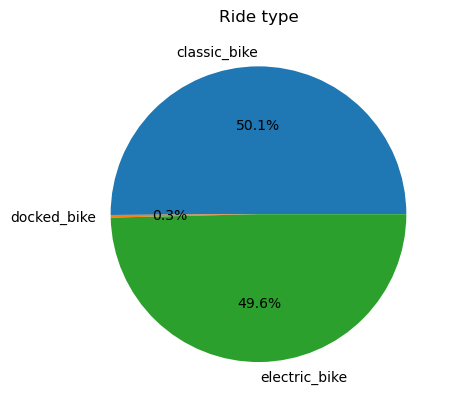

In [47]:
# ploting pie chart
fig, ax = plt.subplots()

ax.pie(ride_type['ride_number'], labels = ride_type['rideable_type'].to_list(), autopct='%1.1f%%')
ax.set_title('Ride type')

plt.show()


In [48]:
ride_by_member = df_ltm.groupby(['member_casual','rideable_type']).agg({'ride_id':'count','distance_km':'mean','ride_length_minutes':'mean'}).reset_index()

In [49]:
ride_by_member

,member_casual,rideable_type,ride_id,distance_km,ride_length_minutes
0,casual,classic_bike,976092,2.074145,36.961776
1,casual,docked_bike,15957,2.194553,260.615267
2,casual,electric_bike,1035421,2.175971,14.416903
3,member,classic_bike,1872695,1.915883,14.660571
4,member,electric_bike,1787732,2.371688,11.258597


## Save clean file

In [33]:
df.to_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\Data analytics\data_merged.parquet')

In [45]:
df2.to_parquet(r'C:\Users\tamla_f1yewqh\OneDrive\Desktop\Python\Projects\Divvy\Data analytics\stations.parquet')